In [1]:
import json
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")
color1 = "ch:rot=-.25,hue=1,light=.75"
color2 = "colorblind"

import matplotlib.pyplot as plt

from functions import infopld_normalize, word_normalize, preprocessing_submercado

Neste projeto vamos explorar a relação entre consumo de energia e custo por submercado.

**Datasets** - https://www.ccee.org.br/portal/:
 - consumo.xlsx
 - infopld.xlsx (3 sheets)
 
**Informação auxiliar**:
 - estado2submercado.json (Mapeia estado - submercado)

DESENVOLVER INTELIGENCIA DE MERCADO E FERRAMENTAS COMPUTACION AIS PARA SE DESCOBRI O vALOR DO PLD, POIS A PLD QUE VAI DEFINIR QUAL VAI SER A VERIAÇÃO NO BOLSA DE ENERGIA.


- PLD: preço da liquidação das diferenças (Valoração monetária)

- PLD PARA CIMA
  - OU geração das fontes baratas foi baixa (hidrelétricas)
  - OU CONSUMO ALTO OBRIGANDO TERMOELETRICAS A FICAREM EM OPERAÇÃO
- PLD - PARA BAIXO
  - OU a geração das fontes baratas foi alta 
  - OU o consumo foi BAIXO


## Loading data 

In [2]:
# Carregando os dados
consumo_df = pd.read_excel("data/consumo.xlsx")
infopld = pd.ExcelFile("data/infopld.xlsx")
infopld_2018_df = infopld.parse("PLD2018",encoding='ISO-8859-1') 
infopld_2019_df = infopld.parse("PLD2019") 
infopld_2020_df = infopld.parse("PLD2020") 


"""
Submercados é um conjunto de estados melhor conectados por linha de transmissão ... ou seja ... o fluxo de energia entre eles é muito maior. 
"""
with open("data/estado2submercado.json", "r") as f:
    submercados = json.load(f)

## Cleaning 

In [3]:
# auxiliar info cleaning
estado2submercado = preprocessing_submercado(submercados)

#Consumo cleaning
estados_clean = consumo_df["Estado"].str.normalize('NFKD')\
                                    .str.encode('ascii', errors='ignore')\
                                    .str.decode('utf-8')\
                                    .str.strip()\
                                    .str.lower()

clean_data = pd.to_datetime(consumo_df['Data'], format='%d/%m/%Y', errors='raise')

consumo_df = consumo_df.assign(Estado = estados_clean)\
                       .assign(Data=clean_data)\
                       .fillna(method="ffill")\
                       .replace({"Estado":estado2submercado})\
                       .rename(columns={"Estado":"submercado"})\
                       .groupby(["Data","submercado"], as_index=False).agg(np.mean)

# Vamos trabalhar com uma informação mensal
consumo_df["Data"] = consumo_df["Data"].apply(lambda x: pd.to_datetime(f"{x.year}-{x.month}-1"))
consumo_df = consumo_df.groupby(["Data", "submercado"], as_index=False).agg(np.mean)

#pld cleaning
infopld18_clean = infopld_normalize(infopld_2018_df)
infopld19_clean = infopld_normalize(infopld_2019_df)
infopld20_clean = infopld_normalize(infopld_2020_df)

## Analysis 

In [4]:
aux1 = infopld18_clean.melt(id_vars = ['submercado','semana'] ,var_name='data', value_name='pld')
aux2 = infopld19_clean.melt(id_vars = ['submercado','semana'] ,var_name='data', value_name='pld')
aux3 = infopld20_clean.melt(id_vars = ['submercado','semana'] ,var_name='data', value_name='pld')

In [5]:
weekly_df = pd.concat([aux1, aux2, aux3],ignore_index=True)
weekly_df[["Year", "Month"]] = weekly_df.apply(lambda x: (x['data'].year, x['data'].month), axis = 1, result_type='expand')
weekly_df["Month"] = weekly_df["Month"].astype(str)
weekly_df["Year"] = weekly_df["Year"].astype(str)

### Consumo vs Meses 

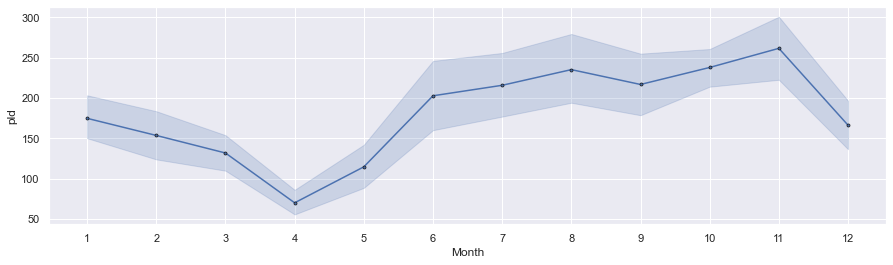

In [6]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(x="Month", y="pld", data=weekly_df, palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
plt.show()

MOTIVO OU HIPÓTESE:

PLD é muito baixo em abril pq a geração de energia pelas fontes hidrelétricas são muito altas nesse período.

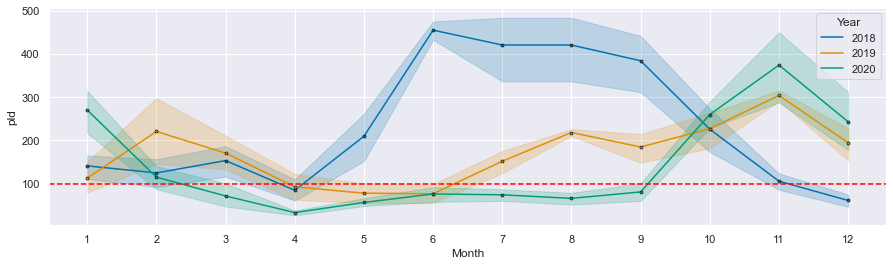

In [7]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(x="Month", y="pld", hue="Year", data=weekly_df, palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
plt.axhline(y=100, lw=1.5, ls='--', c='red')
plt.show()

2018:


2020:
- O preço da energia entre Março e Setembro de 2020 foi muito barato.
- Uma abertura das restrições da pandemia -> Houve um aumento do consumo da energia? 


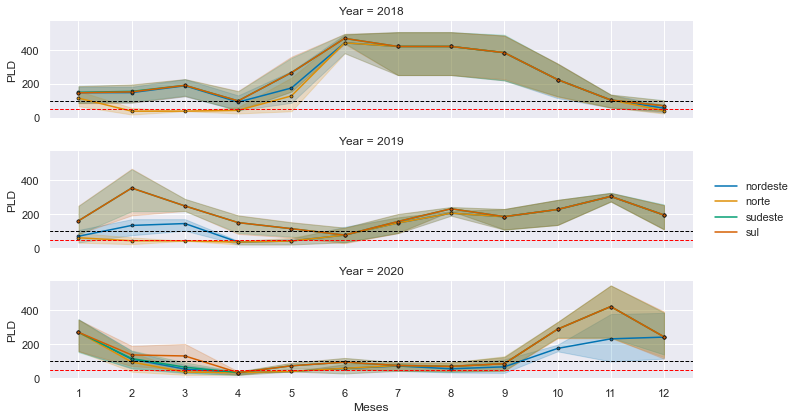

In [8]:
g = sns.FacetGrid(weekly_df, row="Year", height=2, aspect=5)
g.map_dataframe(sns.lineplot, x="Month", y="pld", hue='submercado', 
                palette=color2, marker='o', markersize=3, mec='k', lw=1.5)

g.map(plt.axhline, y=100, lw=1, ls='--', c='black')
g.map(plt.axhline, y=50,  lw=1, ls='--', c='red')

g.set_axis_labels("Meses", "PLD")
g.add_legend()
g.tight_layout()
plt.show()

Os efeitos aconteceram em um nível nacional

### Outras visualizações

Uma variação muito alta de um mês para outro -> E isso leva a motivação, descobrir o preço da energia nos meses futuros.

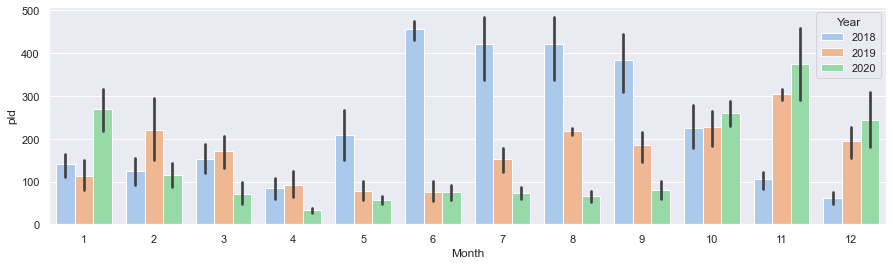

In [9]:
fig = plt.figure(figsize=(15,4))
sns.barplot(x="Month", y="pld", data=weekly_df,
            hue='Year',color="b", palette='pastel')
plt.show()

Podemos trabalhar em cima de diferenças mais especificas.

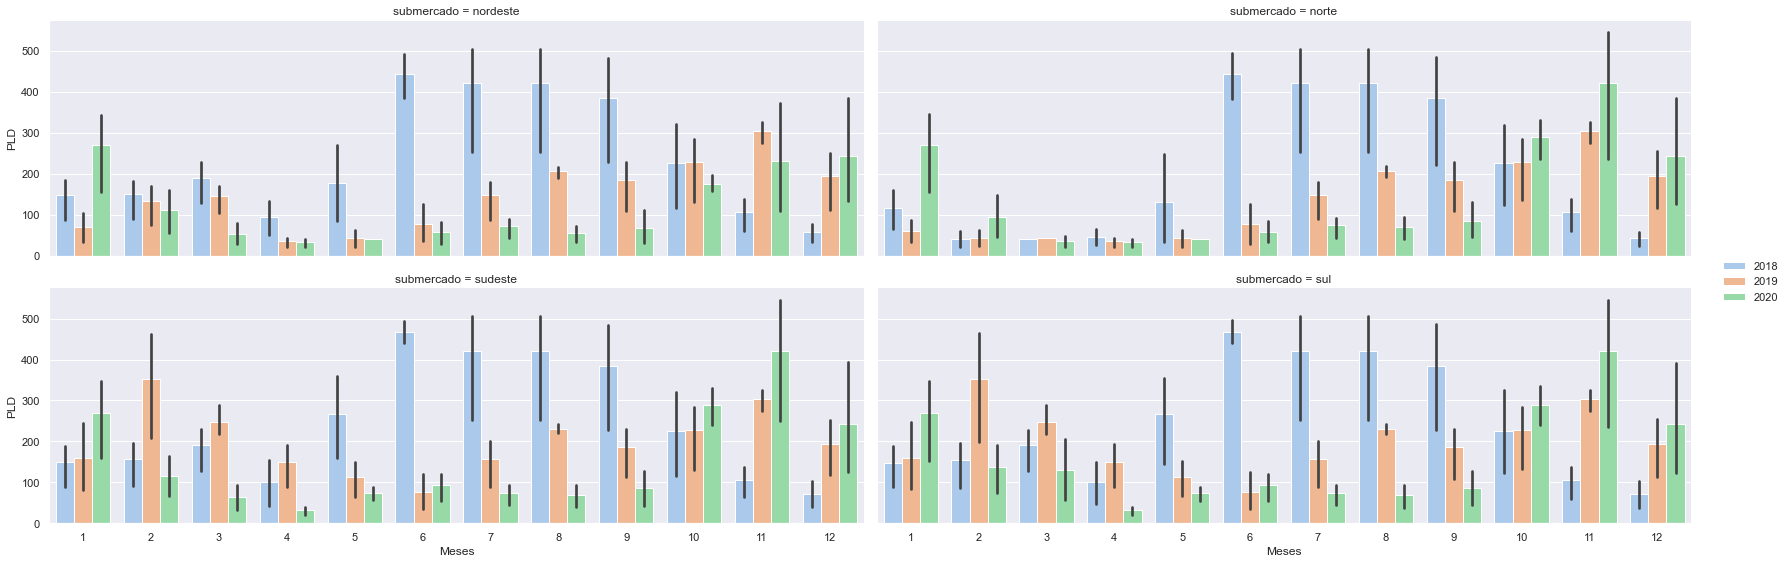

In [10]:
g = sns.FacetGrid(weekly_df, col="submercado", col_wrap=2, height=4, aspect=3)
g.map_dataframe(sns.barplot, x="Month", y="pld", hue='Year', palette='pastel')

g.set_axis_labels("Meses", "PLD")
g.add_legend()
g.tight_layout()
plt.show()

**Vamos ver a série histórica completa da pld:**

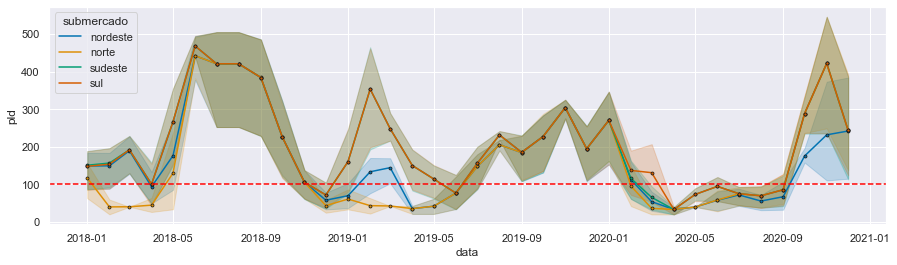

In [11]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(x="data", y="pld", hue ="submercado", data=weekly_df, palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
plt.axhline(y=100, lw=1.5, ls='--', c='red')
plt.show()

### Consumo vs preço 

In [12]:
columns18_agg = infopld18_clean.filter(regex=r"\d{4}-\d{2}-\d{2}").columns
columns19_agg = infopld19_clean.filter(regex=r"\d{4}-\d{2}-\d{2}").columns
columns20_agg = infopld20_clean.filter(regex=r"\d{4}-\d{2}-\d{2}").columns
aux1=pd.pivot_table(infopld18_clean, values = columns18_agg, index='submercado', aggfunc=np.mean, fill_value=0).T
aux2=pd.pivot_table(infopld19_clean, values = columns19_agg, index='submercado', aggfunc=np.mean, fill_value=0).T
aux3=pd.pivot_table(infopld20_clean, values = columns20_agg, index='submercado', aggfunc=np.mean, fill_value=0).T

analysis_df = pd.concat([aux1, aux2, aux3])

analysis_df = analysis_df.reset_index()\
                         .rename(columns={"index":"Data"})

analysis_df = pd.merge(analysis_df.melt(id_vars="Data",value_name="pld"), consumo_df, on=["Data","submercado"])
analysis_df[["Year", "Month"]] = analysis_df.apply(lambda x: (x['Data'].year, x['Data'].month), axis = 1, result_type='expand')
analysis_df["Month"] = analysis_df["Month"].astype(str)
analysis_df["Year"] = analysis_df["Year"].astype(str)

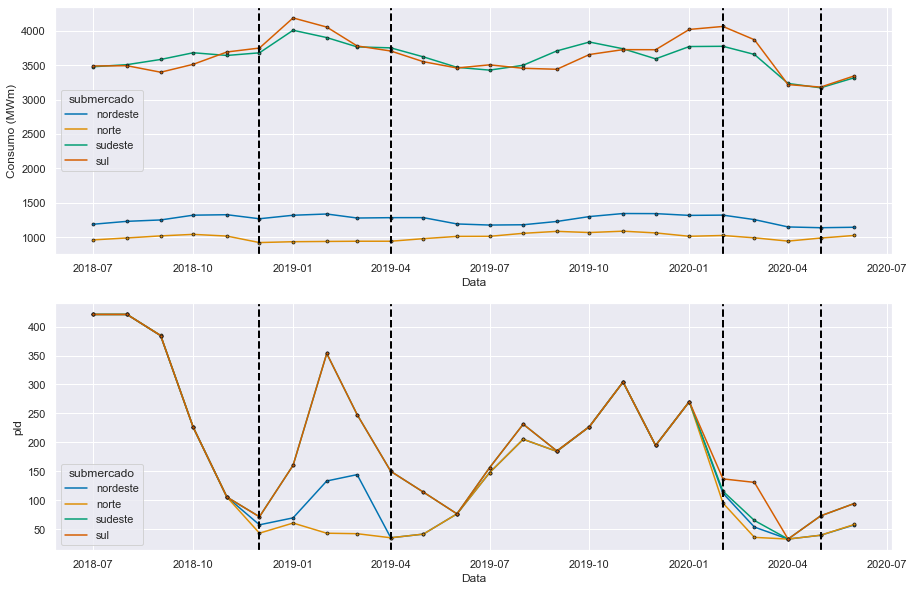

In [13]:
fig, axs = plt.subplots(2,1,figsize=(15,10))

sns.lineplot(
    x="Data", y="Consumo (MWm)",hue="submercado",
    data=analysis_df, ax = axs[0],
    palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
axs[0].axvline(x=pd.to_datetime("2018-12-1"), lw=2, ls='--', c='black')
axs[0].axvline(x=pd.to_datetime("2019-04-1"), lw=2, ls='--', c='black')

axs[0].axvline(x=pd.to_datetime("2020-02-1"), lw=2, ls='--', c='black')
axs[0].axvline(x=pd.to_datetime("2020-05-1"), lw=2, ls='--', c='black')


sns.lineplot(
    x="Data", y="pld", hue ="submercado", 
    data=analysis_df, ax = axs[1],
    palette=color2, marker='o', markersize=3, mec='k', lw=1.5)

axs[1].axvline(x=pd.to_datetime("2018-12-1"), lw=2, ls='--', c='black')
axs[1].axvline(x=pd.to_datetime("2019-04-1"), lw=2, ls='--', c='black')

axs[1].axvline(x=pd.to_datetime("2020-02-1"), lw=2, ls='--', c='black')
axs[1].axvline(x=pd.to_datetime("2020-05-1"), lw=2, ls='--', c='black')

plt.show()

Apesar de o consumo ser muito baixo nos submercados do norte e nordeste o preço da energia é similar. 

Isso acontece porque existe uma exportação e importação entre submercados, mas para checar isso precisariamos de outras variáveis.